# LDA Model - Maleficent
### Sirius 

In [1]:
# import the ReddditProcess class python script that are based on the RedditProcessing class python script,
#  but also add additional funcitons
from RedditProcess import RedditProcess

# importing packages and nltk data libraries
import string
import json
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from matplotlib.dates import DateFormatter

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer



# Before Text Preprocessing
Codes below are constructed by myself.

In [ ]:
# Input file of reddit posts
jsonFile = 'youtube_maleficent.json'

# Read and process the JSON file
with open(jsonFile, 'r', encoding='utf-8') as f:
    YouTubeVideoData = json.load(f)

### Exploration of Submissions and Comments Activity by Times

In [ ]:
# Create lists to store the extracted timestamps
videos_data = []
comments_data = []
replies_data = []

# Iterate over the list of video dictionaries in YouTubeVideoData
for video in YouTubeVideoData:
    # Get video timestamp
    video_time = datetime.fromtimestamp(video.get('Timestamp', 0))
    videos_data.append(video_time)
    
    # Get comments timestamps (note the capital 'C' in 'Comments')
    comments = video.get('Comments', [])
    if comments:
        for comment in comments:
            comment_time = datetime.fromtimestamp(comment.get('timestamp', 0))
            comments_data.append(comment_time)
            # Get replies timestamps
            replies = comment.get('replies', [])
            if replies:
                for reply in replies:
                    reply_time = datetime.fromtimestamp(reply.get('timestamp', 0))
                    replies_data.append(reply_time)

# Convert to pandas DataFrames for better time series analysis
df_comments = pd.DataFrame({'timestamp': comments_data, 'type': 'Comment'})
df_replies = pd.DataFrame({'timestamp': replies_data, 'type': 'Reply'})

# Combine data for visualizations
df_combined = pd.concat([ df_comments, df_replies])

# Basic information of dataset
print("Activity Statistics:")
# print(f"Total Videos: {len(videos_data)}")
print(f"Total Comments: {len(comments_data)}")
print(f"Total Replies: {len(replies_data)}")
print(f"Total Activity: {len(df_combined)}")
print(f"\nDate Range: \n{min(df_combined['timestamp']).date()} to {max(df_combined['timestamp']).date()}")

Activity Statistics:
Total Comments: 9452
Total Replies: 3592
Total Activity: 13044

Date Range: 
2014-05-22 to 2025-05-22


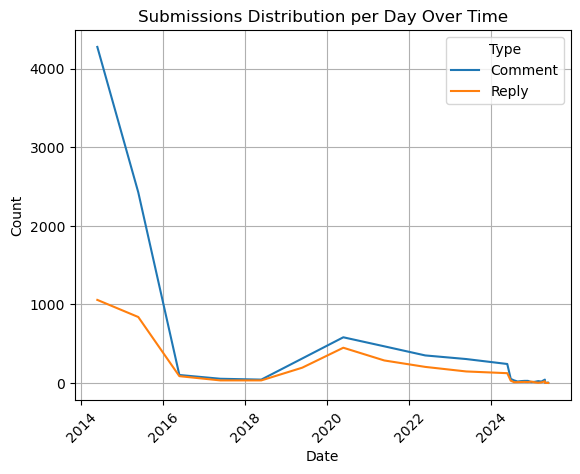

In [4]:
# Submissions distribution per day
df_combined['date'] = df_combined['timestamp'].dt.date
df_day = df_combined.groupby(['date', 'type']).size().unstack(fill_value=0)
df_day.plot(kind='line')
plt.title('Submissions Distribution per Day Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Type')
plt.grid(True)

# Text Preprocessing

In [5]:
# Define tokenizer
tweetTokenizer = TweetTokenizer()

# Build punctuation list and stopwords list
lPunct = list(string.punctuation)
lStopwords = stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '..','"', "'", '`', '’','@']

# Create a stemmer instance
stemmer = PorterStemmer()

# Call the RedditProcess python script
redditProcessor = RedditProcess(tweetTokenizer, lStopwords, stemmer)

# Create an empty list to store tokens after text preprocessing
TokensData = []

# Perform text preprocessing for submissions and comments
# Perform text preprocessing for videos, comments, and replies
for video in YouTubeVideoData:
    # Process video title
    video_title = video.get('Title', '')
    if video_title:
        tokens = redditProcessor.process(video_title)
        TokensData.append(tokens)

    # Process video description
    video_description = video.get('Description', '')
    if video_description:
        tokens = redditProcessor.process(video_description)
        TokensData.append(tokens)

    # Process comments
    comments = video.get('Comments', [])
    for comment in comments:
        comment_text = comment.get('text', '')
        if comment_text:
            tokens = redditProcessor.process(comment_text)
            TokensData.append(tokens)

        # Process replies to this comment
        replies = comment.get('replies', [])
        for reply in replies:
            reply_text = reply.get('text', '')
            if reply_text:
                tokens = redditProcessor.process(reply_text)
                TokensData.append(tokens)

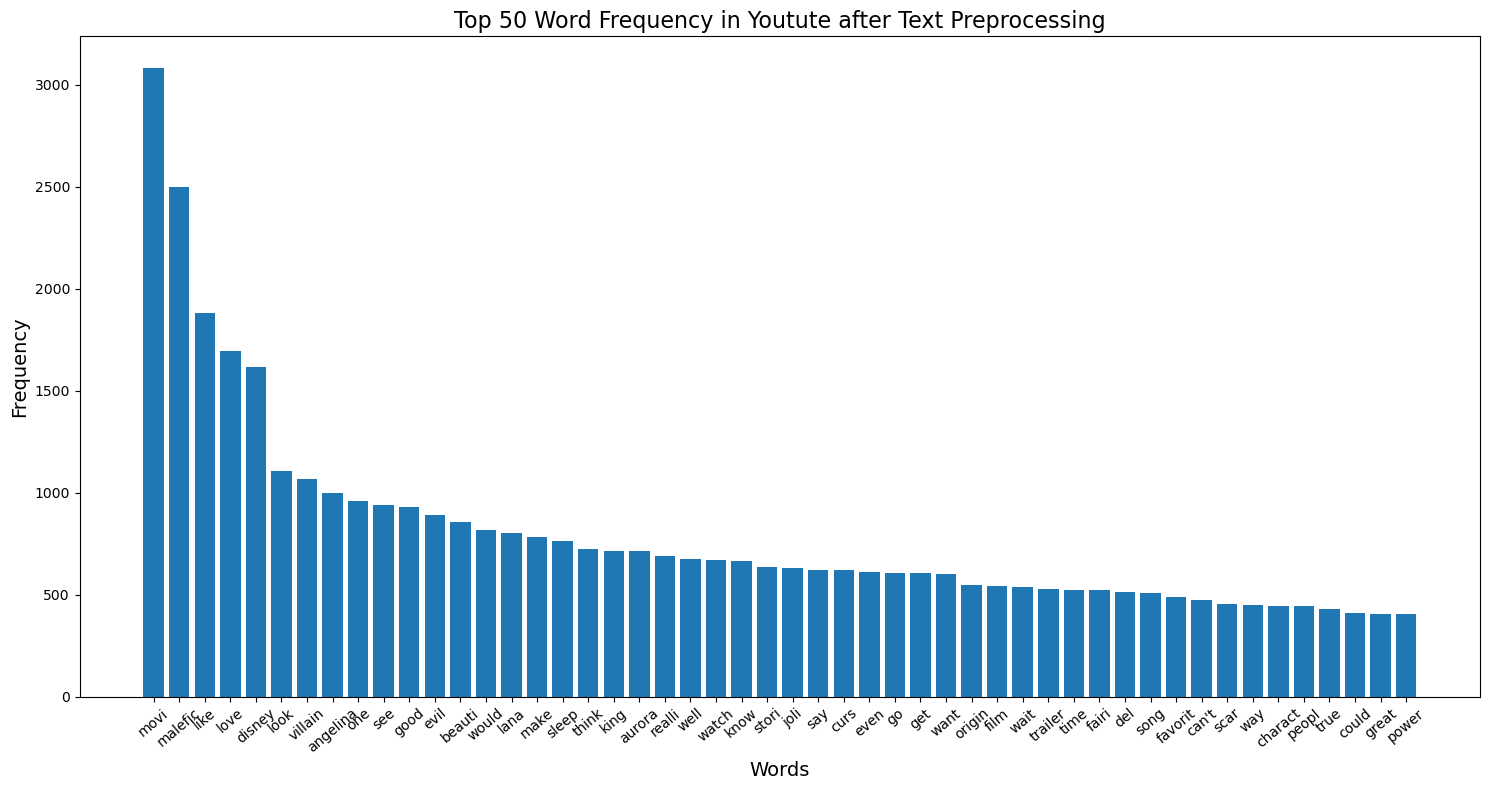

In [6]:
# Count frequencies of each token
token_counts = Counter()
for token_list in TokensData:
    token_counts.update(token_list)

# Get the 50 most common terms
top_50 = token_counts.most_common(50)

# Split into terms and counts
terms, counts = zip(*top_50)

# Plot
plt.figure(figsize=(15, 8))
plt.bar(terms, counts)
plt.xticks(rotation=40)
plt.xlabel('Words',fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('Top 50 Word Frequency in Youtute after Text Preprocessing', fontsize = 16)
plt.tight_layout()
plt.show()

# LDA model

### Reference: Codes below are from COSC2671 Social Media and Network Analytics Workshop 6, created by Jeffrey Chan, RMIT University, 2023.

In [7]:
import numpy as np
import math
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [8]:
#
# LDA parameters
#

# number of topics to discover (default = 10)
topicNum = 9
# maximum number of words to display per topic (default = 10)
# Answer to Exercise 1 (change from 10 to 15)
wordNumToDisplay = 10
# this is the number of features/words to used to describe our documents
featureNum = 5000

In [9]:
lPosts = []

# Loop through each list of tokens (each submission and comment)
for single_submission_tokens in TokensData:
    post_string = ' '.join(single_submission_tokens)
    lPosts.append(post_string)  # Append the resulting string for this submission to lPosts

In [10]:
#
# Count Vectorizer
#
# Transforms text into a sparse matrix of n-gram counts.
tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(lPosts)


# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()

#
# LDA MODEL
#

# Run LDA (see documentation about what the arguments means)
ldaModel = LatentDirichletAllocation(n_components = topicNum, max_iter=10, learning_method='online').fit(tf)

In [12]:
def display_topics(model, featureNames, numTopWords):
    """
    Prints out and returns the most associated words for each topic.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    @return: list of strings, each representing a topic and its top words.
    """
    topic_list = []
    for topicId, lTopicDist in enumerate(model.components_):
        Id = "Topic %d:" % (topicId)
        words = " ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]])
        topic_str = f"{Id} {words}"  
        print(topic_str)
        topic_list.append(topic_str) # To save the topic and its top words
    return topic_list
                

### pyLDAvis

In [13]:
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne', n_jobs=1)
pyLDAvis.display(panel)

In [14]:
pyLDAvis.save_html(panel, fileobj="output.html")

### Wordcloud

In [15]:
def displayWordcloud(model, featureNames):
    """
    Displays the word cloud of the topic distributions, stored in model.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    """

    # this normalises each row/topic to sum to one
    # use this normalisedComponents to display your wordclouds
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]

    # TODO: complete the implementation

    topicNum = len(model.components_)
    # number of wordclouds for each row
    plotColNum = 3
    # number of wordclouds for each column
    plotRowNum = int(math.ceil(topicNum / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.tight_layout(rect=[0, 0.03, 2, 1.5])
        plt.axis("off")

    plt.show(block=True)

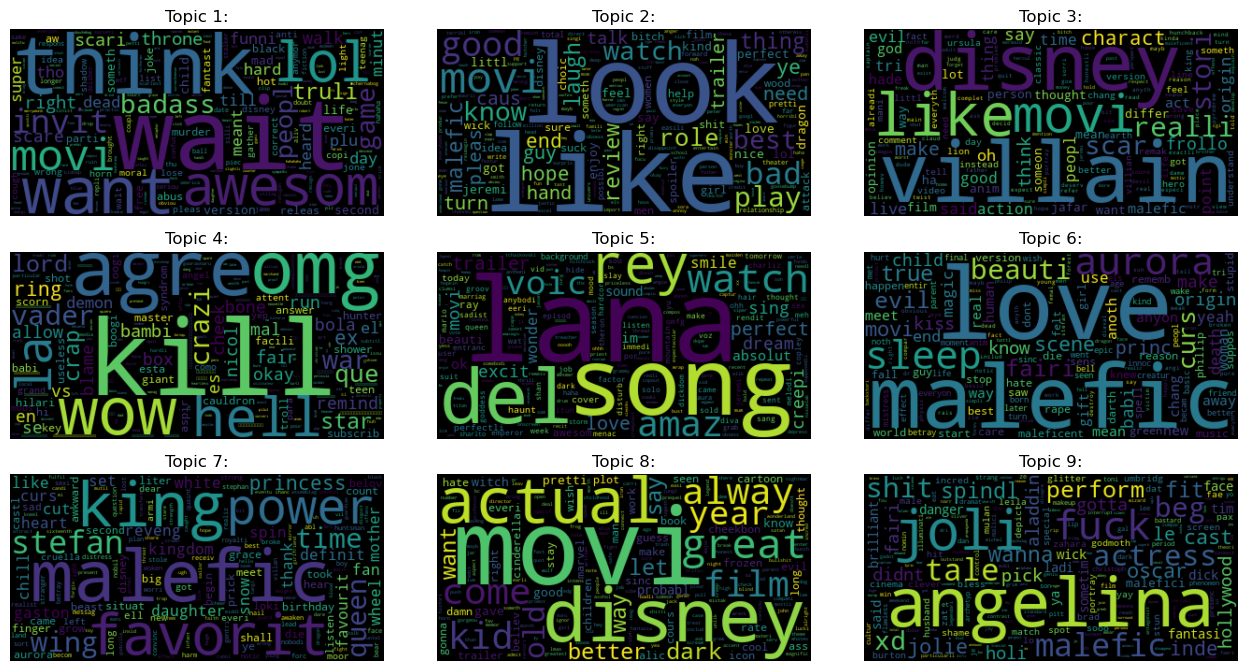

In [ ]:
displayWordcloud(ldaModel, tfFeatureNames)